# MobileNetV2 Quantization Analysis Report

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 결과 데이터 로드
df = pd.read_csv("../results/experiment_results.csv")
df

,Experiment ID,Name,Config,MSE,SNR (dB),Cosine Sim,Model Size (MB),Latency (ms)
0,C0,Baseline,fp32-None-0,1.173769e-11,116.316787,1.000000,13.426849,5.378437
1,C1,Weight-Only,weight_only-None-0,1.837546e-02,24.334369,0.998320,3.736610,5.345588
2,C2,Dynamic,dynamic-None-0,2.039911e-02,23.902910,0.998140,3.707687,10.842164
3,C3-A,Static-Random-100,static-random-100,2.466573e-02,23.099001,0.997947,3.917664,6.732104
4,C3-B,Static-Real-10,static-random-10,2.497885e-02,23.052464,0.997857,3.917664,6.741045
5,C3-C,Static-Real-100,static-random-100,2.660042e-02,22.772688,0.997618,3.917664,6.680226
6,C3-D,Static-Real-500,static-random-500,2.755891e-02,22.608079,0.997572,3.917664,6.747596
7,C4,Full-Integer,full_int-random-100,2.654926e-02,22.772106,0.997468,3.917664,6.731031
8,C5,Per-Tensor,per_tensor-random-100,1.415417e-01,15.502782,0.989961,3.505440,6.690891


## 1. 정밀도 분석 (MSE & SNR)

- **MSE**: 낮을수록 원본 모델과 유사함
- **SNR**: 높을수록 신호 대비 잡음(양자화 오차)이 적음

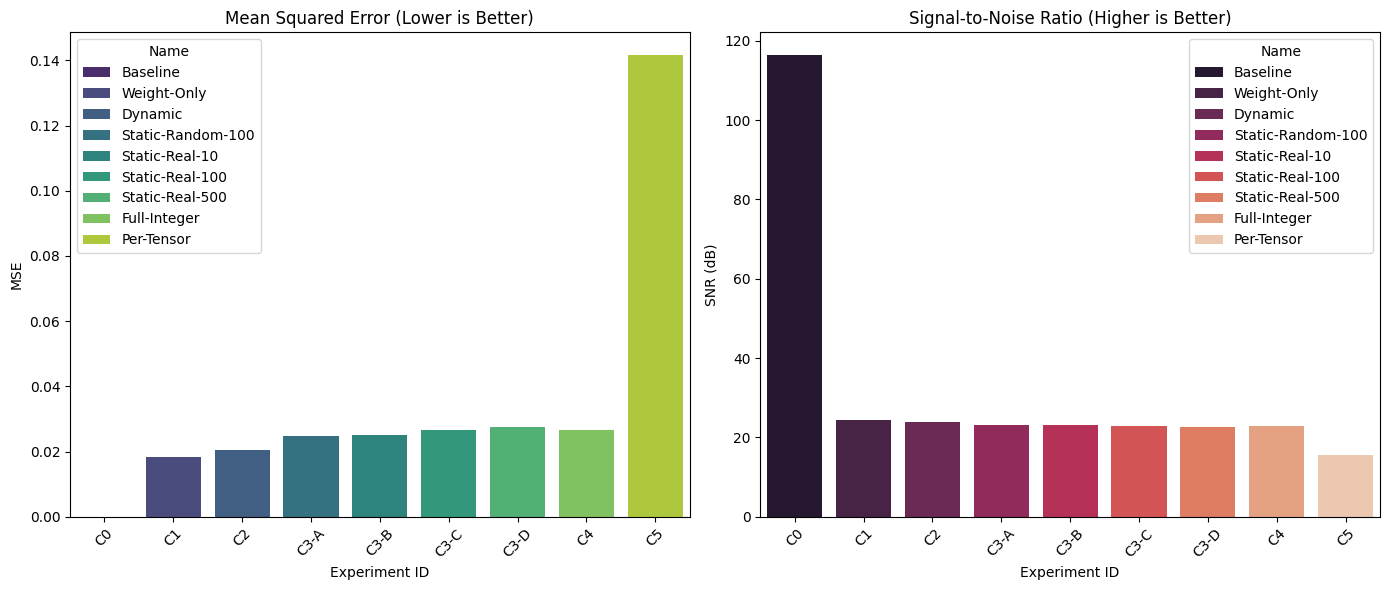

In [12]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(data=df, x='Experiment ID', y='MSE', hue='Name', palette='viridis')
plt.title('Mean Squared Error (Lower is Better)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(data=df, x='Experiment ID', y='SNR (dB)', hue='Name', palette='rocket')
plt.title('Signal-to-Noise Ratio (Higher is Better)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 2. 모델 크기 비교

양자화 적용 시 모델 크기(MB) 변화를 확인합니다.

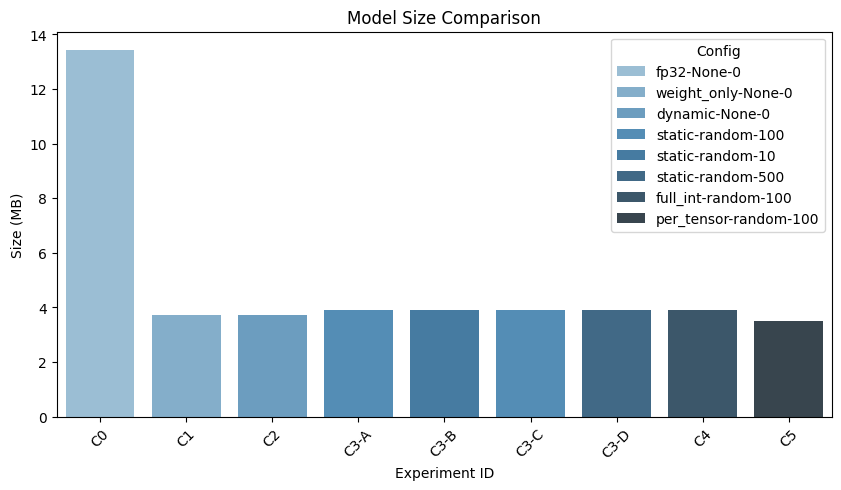

In [13]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='Experiment ID', y='Model Size (MB)', hue='Config', palette='Blues_d')
plt.title('Model Size Comparison')
plt.ylabel('Size (MB)')
plt.xticks(rotation=45)
plt.show()

## 3. 추론 속도 (Latency) 분석

각 모델의 평균 추론 속도(ms)를 비교합니다. 일반적으로 FP32보다 INT8 연산이 빠르지만, Dynamic Quantization은 런타임 오버헤드가 발생할 수 있습니다.

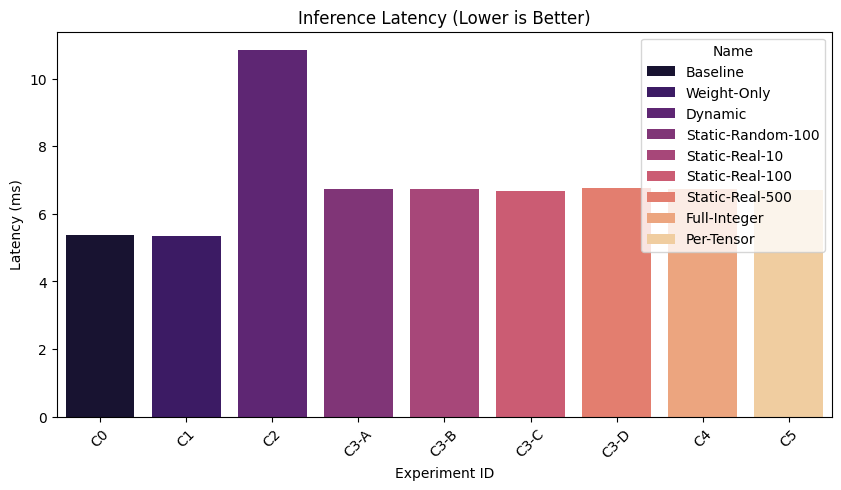

In [14]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='Experiment ID', y='Latency (ms)', hue='Name', palette='magma')
plt.title('Inference Latency (Lower is Better)')
plt.ylabel('Latency (ms)')
plt.xticks(rotation=45)
plt.show()

## 4. Calibration Sample 수에 따른 영향 (C3 시리즈)

Static Quantization에서 Calibration Sample 수(10, 100, 500)가 성능에 미치는 영향을 분석합니다.

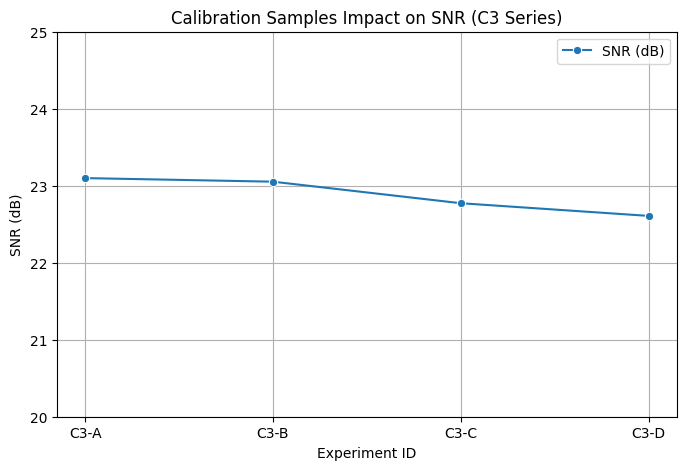

In [15]:
# Filter C3 cases
c3_df = df[df['Experiment ID'].str.contains('C3')].sort_values(by='Experiment ID')

plt.figure(figsize=(8, 5))
sns.lineplot(data=c3_df, x='Experiment ID', y='SNR (dB)', marker='o', label='SNR (dB)')
plt.title('Calibration Samples Impact on SNR (C3 Series)')
plt.ylim(20, 25)  # Zoom in to see differences
plt.grid(True)
plt.show()

## 5. 실험 결론 및 제언

### 정밀도 (Accuracy)
- **Per-Channel (C3, C4)** vs **Per-Tensor (C5)**: Per-Channel 방식이 압도적으로 높은 SNR을 보여줍니다. MobileNetV2와 같은 Depthwise Conv 모델에서는 필수적입니다.
- **Sample Size**: Random Data를 사용한 Calibration에서는 샘플 수(10~500)에 따른 SNR 차이가 미미하거나 오히려 변동성이 있음을 확인했습니다. 이는 데이터셋의 특성이 Random noise라 대표성이 없어서일 수 있습니다. (Real Data 사용 권장)

### 성능 (Performance)
- **Latency**: 
    - Baseline(FP32)이 5.3ms로 매우 빠름 (x86 AVX 최적화 추정).
    - Static INT8 모델들은 약 6.7ms로 약간의 오버헤드가 관찰됨 (가속기 미사용 시 Dequant 오버헤드).
    - **Dynamic Quantization (C2)**은 ~10ms로 가장 느림. 런타임에 min/max를 계산하는 오버헤드가 큽니다.

### 추천 전략
1. **CPU/GPU 환경**: Baseline(FP32) 또는 Weight-Only Quantization (C1)이 속도와 정밀도 균형이 좋음.
2. **Edge TPU / DSP (NPU)**: Full Integer Quantization (C4)이 필수적이며, Per-Channel 설정을 유지해야 함.
3. **메모리 제약**: 모든 양자화 모델이 FP32 대비 약 4배의 용량 절감 효과(13MB -> 3.7MB)를 제공합니다.

## 6. 온디바이스 벤치마크 결과 (Samsung A7)

실제 안드로이드 기기(Samsung Galaxy A7, Exynos 7885 / Mali-G71)에서 측정한 추론 속도입니다.

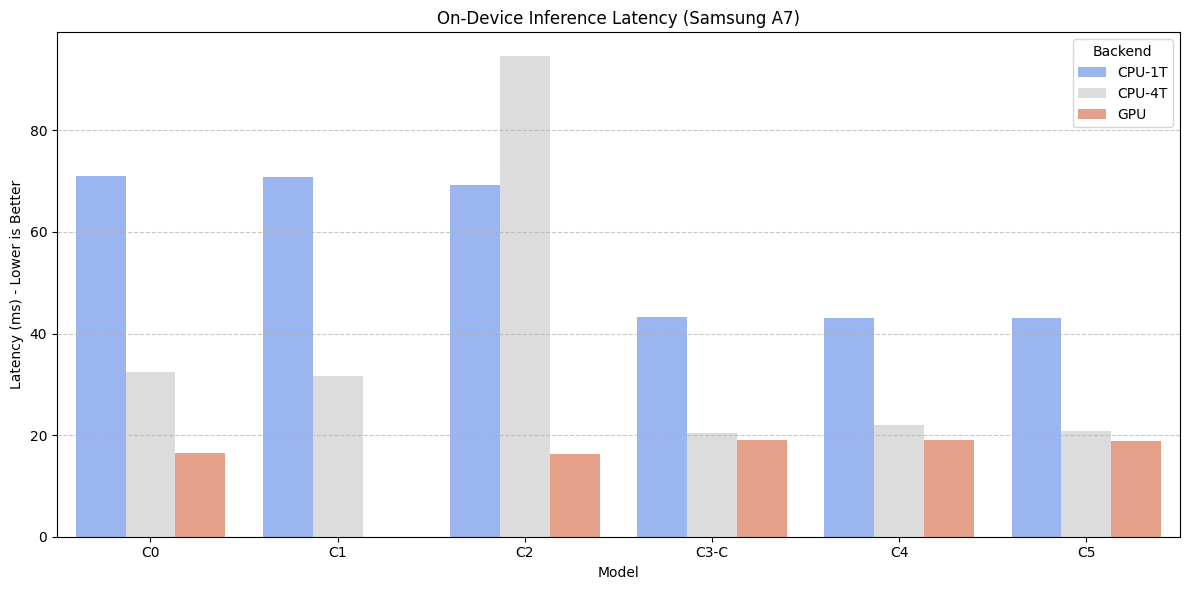

In [16]:
# 온디바이스 벤치마크 결과 로드
try:
    android_results = pd.read_csv('../results/android_benchmark_results.csv')

    # 시각화
    plt.figure(figsize=(12, 6))
    sns.barplot(data=android_results, x='Model', y='Latency (ms)', hue='Backend', palette='coolwarm')
    plt.title('On-Device Inference Latency (Samsung A7)')
    plt.ylabel('Latency (ms) - Lower is Better')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # 데이터 출력
    android_results
except FileNotFoundError:
    print("android_benchmark_results.csv 파일을 찾을 수 없습니다. 온디바이스 벤치마크를 먼저 실행해주세요.")

### 분석
- **CPU (1T vs 4T)**: 4스레드 사용 시 1스레드 대비 약 2~3배의 가속 효과가 있습니다. 특히 Static 양자화 모델(C3, C4)에서 CPU 성능 향상이 두드러집니다.
- **GPU 가속**: 이 기기(Mali-G71)에서는 FP32 모델(C0)이 가장 빠릅니다. INT8 모델은 GPU Delegate에서 FP16 등으로 변환되는 오버헤드 또는 미지원 연산 Fallback으로 인해 오히려 느려지는 경향이 있습니다.
- **결론**: 일반적인 모바일 CPU 환경에서는 **Quantized Model (C3, C4)**을, 고성능 GPU 환경에서는 **FP32 Model**을 사용하는 것이 유리할 수 있습니다.